In [33]:
import praw 
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

import nltk
from nltk.tokenize import word_tokenize

In [3]:
with open("reddit_auth.json") as filename:
    auth = json.load(filename)

reddit = praw.Reddit(client_id=auth["client_id"],
                     client_secret=auth["client_secret"],
                     user_agent="stocks_test")

In [6]:
#Basic information about stocks
stocks = pd.read_csv("NASDAQ_names.csv", index_col="Symbol")[["Name", "Last Sale", "Market Cap", "Country", "Sector"]]

stocks["Last Sale"].fillna("$0", inplace=True)

for i in stocks.index:
    stocks["Last Sale"][i] = float(stocks["Last Sale"][i][1:])

save_loc = "/Users/connorhughes/Desktop/Coding/Reddit stonks/Figures/"

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [9]:
stocks.head()

,Name,Last Sale,Market Cap,Country,Sector
Symbol,,,,,
A,Agilent Technologies Inc. Common Stock,119.3,3.650580e+10,United States,Capital Goods
AA,Alcoa Corporation Common Stock,22.01,4.092310e+09,NaN,Basic Industries
AACG,ATA Creativity Global American Depositary Shares,1.2002,3.762687e+07,China,Consumer Services
AACQ,Artius Acquisition Inc. Class A Common Stock,10.43,9.445669e+08,United States,Finance
AACQU,Artius Acquisition Inc. Unit,10.98,0.000000e+00,United States,Finance


In [10]:
subreddit = reddit.subreddit("thewallstreet")

submissions = subreddit.hot(limit=50)

In [12]:
posts = []

for submission in submissions:
    if ("Daily" in submission.title) or ("Post Market" in submission.title) or ("Nightly" in submission.title):
        post = {}
        post["title"] = submission.title
        post["id"] = submission.id
        post["comments"] = submission.comments
        posts.append(post)

In [19]:
tickers = {}

for post in posts:
    for comment in post["comments"][:-1]:

        body = comment.body
        body_words = word_tokenize(body)

        for symbol in stocks.index:
            if symbol in body_words:

                if symbol in tickers.keys():
                    tickers[symbol]["comments"].append(body)
                    tickers[symbol]["num_comments"] += 1
                else:
                    tickers[symbol] = {"num_comments": 1, "comments": [body]}




In [20]:
symbols = []
num_comments = []

for k, v in tickers.items():

    if v["num_comments"] > 2:
        symbols.append(k)
        num_comments.append(v["num_comments"])

num_df = pd.DataFrame({"Symbol": symbols, "num_comments": num_comments})

num_df.sort_values("num_comments", ascending=False, inplace=True)


Text(0.5, 0, 'Number of mentions')

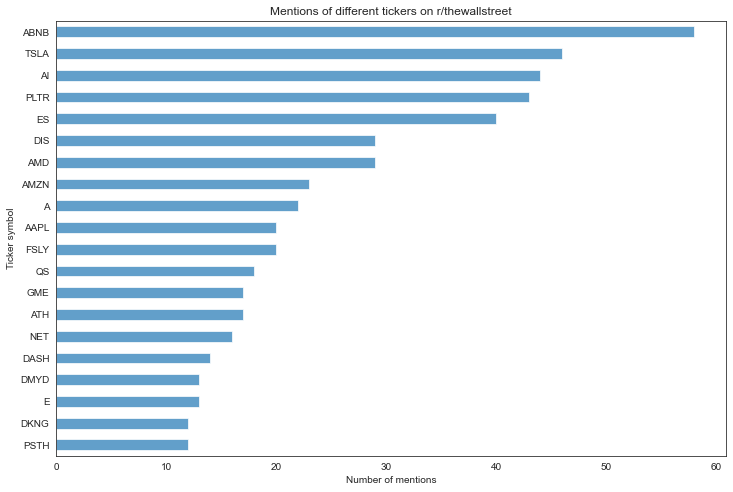

In [21]:
limit = 20

ax = num_df.iloc[:limit].plot.barh(x="Symbol", y="num_comments", alpha=0.7, legend=False, figsize=(12, 8))
ax.invert_yaxis()

plt.title("Mentions of different tickers on r/thewallstreet")

plt.ylabel("Ticker symbol")
plt.xlabel("Number of mentions")

#plt.savefig(f"{save_loc}mentions.jpg", dpi=300)

In [24]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [25]:
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [31]:
for post in posts:
    comment_polarity = []
    for comment in post["comments"][:-1]:
        body = comment.body
        polarity_of_comment = getPolarity(body)
        comment_polarity.append(polarity_of_comment)
        
        if polarity_of_comment>0.4 or polarity_of_comment<-0.4:
            display(body)
            display(polarity_of_comment)
        
    post["polarity"] = comment_polarity


'Space X raising more money. Literally launching money into space'

0.5

'Cathie made some interesting moves. Selling CRWD. Buying AAPL.'

0.5

"I didn't know our biggest bear capitulated. That explains the dump today. Top is in."

0.5

'Sold three ~~spoos~~ beet here at 19.5k. Think there is an easy yeezy/pop to be made here.'

0.43333333333333335

'Eggnogg - Is it delicious or does it taste like nail polish? Are the two even mutually exclusive?'

1.0

'The $DM fiasco was great for me because I was able to buy back in around 17 after having sold out of my $TRNE at around 18.xx.'

0.43333333333333335

'[https://imgur.com/a/SGnOFgn](https://imgur.com/a/SGnOFgn)\n\nOkay, I added to the position overnight Bc price action had no conviction. Good day. 4 trades.'

0.4333333333333333

'Did well with the 0DTE 3660Ps, was holding as many as 17 at one point. TDA must love me with all the comms I pay \n\nAlso bought so many calls at EOD that it hurts - just how i like it'

0.5

'Some bad news come out about SHOP?'

-0.6999999999999998

'One of the best day! Account up 7% all from $AMD. Thanks, Su Bae!'

0.625

'Ugh .02 off from buying a vxx call this morning that I sold Friday. It’s up 25 percent\n\nNice to see BFT hold onto some of its gains today.\n\nBe interesting what tomorrow brings\n\nWas looking at a 100C for AMD but didn’t pull the trigger'

0.55

'Really good day 6/6 all on the short side. Probably would’ve worked out better just holding but taking targets is just helping discipline. Great day nice red trend been a while'

0.43333333333333335

'Wtf is going on with $RDS.B !!! I was promised trendies!!!!'

-1.0

'Any cyber security people want to weigh in on how bad SolarWinds is?'

-0.6999999999999998

'wonder how many chasers got sucked in on the initial pop this morning lol'

0.43333333333333335

'TV\'s needle on AMD is pointing to a "Strong buy". Trust that needle.'

0.4333333333333333

'What should bbys first stock be?\n\nPLTR?    LMAO\n\nBFT?\n\nTQQQ?'

0.425

'who had VA fill on deck today? I know i didnt lol'

0.8

"What's a good price too get into ABNB?"

0.7

'The good doctor did say that gap fills are one of the more easier trades, yessir he shure did'

0.6

'Anyone else chat with their trade desk just to see what they think about obscure trade ideas lol'

0.8

'Spoos is anti vax confirmed!'

0.5

'>\tTECH GIANTS SAID TO FACE EU FINES AS HIGH AS 10% ANNUAL REVENUE\n\nGoogle not having a great day.'

0.48000000000000004

"Got filled for 200 shares of SPCE at 26.82, I'll take it\n\nEdit: Stopped back out at 27.15 lol oh well"

0.4000000000000001

'internals are very strong at the moment'

0.5633333333333334

':D'

1.0

'AI about to pop\n\nEdit: phew, glad I didn’t pull the trigger on that trade'

0.5

'TIL that it costs 800cad for a McDonald’s chicken nuggets body pillow.'

-0.6

'What would you say was the best TV series of 2020, new or continuation?'

0.5681818181818181

'What do you think the worst headline this week will be?'

-1.0

'HZON\n\nu/marcusmilli\n\n\nProbably your best bet for only fans'

0.5

'Hung out with a buddy tonight and drank some weller 107 and lordy that is some delicious juice'

1.0

'In case anyone missed it, [MSFT](https://ibb.co/crqfSCF) and [AMZN](https://ibb.co/6rtVyVL) both look really nice right now.'

0.44285714285714284

'I would like BA and QCOM to fly tomorrow'

0.8

'decent gap up on the fairly good weekend news'

0.4333333333333333

'Cert and ABnB  not treating me well this morning lol'

0.8

"Sorting the sub for Top Posts/All Time is a God damn gold mine.  This subreddit might be the most valuable place I've found online.  Futures.io is pretty damn good too, but you guys take the CAKE!"

0.53125

'What a lame ass Friday close - all my yolos died'

-0.5

'[crazy deal, BUY BUY BUY!!!](https://store.wsj.com/v2/US/US/1130800064?wsjuswba20a/?trackingCode=aaqwzr72&cid=WSJ_IE_NA_ACQ_NA&n2IKsaD9=n2IKsaD9&Pg9aWOPT=Pg9aWOPT&Cp5dKJWb=Cp5dKJWb&APCc9OU1=APCc9OU1)'

-0.6

'lame lame lame'

-0.5

"OMG I just looked at DIS. I'm RICH!"

0.46875

"SHOP 1055c here /u/wiggz420, in for 2.95, don't follow unless you're fine with losing it all lol"

0.6083333333333334

'I want my abnb refund. I was told it was 200 easy.'

0.43333333333333335

"A break  towards 3600 would be a nice zone to start Santa's sleigh. Doubt we get that lower."

0.6

'Just fill the gap already!!!! WTF market?'

-0.5

"+100% from the lows on Disney\n\nWho'd have thought the mouse would pull through like that? :-)"

0.5

'My COST c spreads are expiring worthless today'

-0.8

'This is looking kinda ugly...'

-0.7

'ROKU up 100% in 3 months lol..'

0.8

'come on u/hibernating_brain\n\nTOP 3 HERE YOU COME'

0.5

'Will those morning buyers step in again to save this level?\n\nE:  would like a ONL retest, otherwise going to be awfully boring session.'

-1.0

'CRSR still being a widowmaker. At an interesting fib level today.'

0.5

'Sold my API shares that got put to me at 35.91 here at 44.65, around 4 stimmies (500 shares). Debated selling at Jan 4th for tax reasons but want to lighten up even more. Could be mistake\n\nu/MrMaisel front run me on this and buy calls quickly, its going to 65 u/BoatshoesJax'

0.41666666666666663

'ROKU with some awesome intraday moves, anyone catch?'

1.0

'I normally look at my DIS position and wonder why I didnt just buy more ROKU or APPS.... but not today. Every thorn has its rose.'

0.4166666666666667

'Out of AI @ 121.31 avg. \n\nDone for the day. See you on the random thread!\n\nEdit: Jesus I should have held'

-0.625

'NVDA at an interesting level.  100 dma and meme line.\n\nhttps://imgur.com/a/XZ2cdfH'

0.5

'AMD looks to be creating a falling wedge* today (5m). Holding up relatively well. CCJ is a beast also.\n\nEdit: also, I’m sure vix is helping my options a bit. New Cudi is awesome'

0.40909090909090906

'/u/wiggz420  quick say the jingle!'

0.41666666666666663

'man msft is incredibly strong today'

0.4333333333333333

'Is anyone touching airlines?'

0.5

'Added more DMYD (300 shares) at 12.87. Likes the 13.4x a lot.'

0.5

'Went to the gym, and missed the TSLA dip. 600 calls went from 4.41 to 14.00. DAMN. Stupid leg days.'

-0.7999999999999999

"There's nothing better than finding a new (good) pizza joint close to your house.\n\nGramma slice ftw"

0.4454545454545455

'Damn AMZN I fucked up I get it'

-0.6

"Thanks to whomever mentioned that DIS was having an investor's day today. I bought some calls for it. Looks like it will work out nicely. :)"

0.43333333333333335

'The WSB nightly discussion. LOL.'

0.8

'/HG having a bad day'

-0.6999999999999998

"/u/mechtech\n\nhttps://asia.nikkei.com/Business/Technology/Toyota-s-game-changing-solid-state-battery-en-route-for-2021-debut\n\nthis isn't good for QS, they may have to start trading on 2027E rev lol. may be a nice short tomorrow."

0.525

'dog farts are disgusting.'

-1.0

'Wtf is EVBox (TPGY)'

-0.5

'I had a buy ABNB at 80 on a scammy exchange yesterday which I canceled to play video game. RIP!\n\nhttps://ftx.com/trade/ABNB/USD'

-0.5

'DIS  up 3%. ok.'

0.5

'Bah! Sold GIK right before close to buy more VERU since I’m out of cash. (Transferring main account to IBKR & stuck in limbo for 2 weeks now). \n\nThe official merger announcement came at the close, so if I’d held 5 more minutes would have 300% gains. What are the chances??? lol'

0.4504761904761905

'Roll that beautiful bean footage'

0.85

'Make 3700 great again.  I might have too many calls'

0.65

"Everyone at my gym was watching CNBC and talking about all the IPOs this week. People are jonesing to buy ABNB. I've gotta say there seems to be a bit too much euphoria lol"

0.5

'https://imgur.com/gallery/k1JWzCw\n\nLOL'

0.8

'Getting my roof replaced today, dogs are not having a good time.'

0.7

'PLTR 24.xx today, will delete if wrong'

-0.5

'PLTR 28+ today\n\n\n\nWill delete if wrong'

-0.5

KeyboardInterrupt: 

In [32]:
nasdaq_history = pd.read_csv("/Users/connorhughes/Downloads/Nasdaq_history_5_yrs.csv")
nasdaq_history.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-21,4957.529785,4968.919922,4928.930176,4968.919922,4968.919922,1673400000
1,2015-12-22,4988.680176,5007.770020,4964.080078,5001.109863,5001.109863,1556670000
2,2015-12-23,5025.549805,5046.089844,5020.439941,5045.930176,5045.930176,1591490000
3,2015-12-24,5046.189941,5063.279785,5043.649902,5048.490234,5048.490234,706880000
4,2015-12-28,5032.290039,5041.270020,4999.069824,5040.990234,5040.990234,1310650000


In [36]:
nasdaq_history["day_change"] = np.sign(nasdaq_history["Close"] - nasdaq_history["Open"])

,Date,Open,High,Low,Close,Adj Close,Volume,day_change
30,2016-02-04,4492.479980,4545.520020,4463.990234,4509.560059,4509.560059,2200930000,1.0
31,2016-02-05,4491.479980,4493.189941,4350.370117,4363.140137,4363.140137,2489280000,-1.0
32,2016-02-08,4288.020020,4301.529785,4212.810059,4283.750000,4283.750000,2702070000,-1.0
33,2016-02-09,4224.870117,4329.609863,4222.479980,4268.759766,4268.759766,2465790000,1.0
34,2016-02-10,4318.279785,4369.620117,4280.729980,4283.589844,4283.589844,2448380000,-1.0
35,2016-02-11,4218.810059,4293.220215,4209.759766,4266.839844,4266.839844,2812330000,1.0
36,2016-02-12,4307.290039,4340.129883,4274.149902,4337.509766,4337.509766,1983190000,1.0
37,2016-02-16,4397.950195,4435.959961,4376.520020,4435.959961,4435.959961,2117920000,1.0
38,2016-02-17,4471.660156,4540.779785,4463.509766,4534.060059,4534.060059,2296440000,1.0
39,2016-02-18,4548.100098,4548.470215,4482.770020,4487.540039,4487.540039,1955870000,-1.0


In [38]:
nasdaq_history

,Date,Open,High,Low,Close,Adj Close,Volume,day_change
0,2015-12-21,4957.529785,4968.919922,4928.930176,4968.919922,4968.919922,1673400000,1.0
1,2015-12-22,4988.680176,5007.770020,4964.080078,5001.109863,5001.109863,1556670000,1.0
2,2015-12-23,5025.549805,5046.089844,5020.439941,5045.930176,5045.930176,1591490000,1.0
3,2015-12-24,5046.189941,5063.279785,5043.649902,5048.490234,5048.490234,706880000,1.0
4,2015-12-28,5032.290039,5041.270020,4999.069824,5040.990234,5040.990234,1310650000,1.0
...,...,...,...,...,...,...,...,...
1254,2020-12-14,12447.440430,12543.000000,12432.709961,12440.040039,12440.040039,4458140000,-1.0
1255,2020-12-15,12543.259766,12596.129883,12465.419922,12595.059570,12595.059570,4377950000,1.0
1256,2020-12-16,12611.040039,12687.320313,12566.379883,12658.190430,12658.190430,4561600000,1.0
1257,2020-12-17,12730.780273,12765.250000,12696.349609,12764.750000,12764.750000,4994090000,1.0


In [90]:
import requests
from datetime import datetime
import traceback
import time

#Template URL for using pushshift
url = "https://api.pushshift.io/reddit/{}/search?limit=1000&sort_type=score&sort=desc&subreddit={}&after={}&before={}"
subreddit="wallstreetbets"


def downloadFromUrl(output_filename, object_type, date):
    #Print that code is starting
    print(f"Saving {object_type}s to {output_filename}")

    #Convert date from string to unix time
    day = int(time.mktime(datetime.strptime(date, "%d/%m/%y").timetuple()))
    
    count = 0
    handle = open(output_filename, 'w')
    
    #Generate the URL we will use to search reddit
    formatted_url = url.format(object_type, subreddit, str(day), str(day + 86400)) #set limit to be 24 hours after start time
    json = requests.get(formatted_url, headers={'User-Agent': "Post downloader by /u/Watchful1"})
    time.sleep(1) # avoid pushshift rate limit
    
    try:
        json_data = json.json()
    
        objects = json_data['data']
        for object in objects:
            count += 1
            if object_type == 'comment':
                try:
                    handle.write(str(object['score']))
                    handle.write(" : ")
                    handle.write(datetime.fromtimestamp(object['created_utc']).strftime("%Y-%m-%d"))
                    handle.write("\n")
                    text = object['body']
                    textASCII = text.encode(encoding='ascii', errors='ignore').decode()
                    handle.write(textASCII)
                    handle.write("\n-------------------------------\n")
                except Exception as err:
                    print(f"Couldn't print comment: https://www.reddit.com{object['permalink']}")
                    print(traceback.format_exc())
            elif object_type == 'submission':
                try:
                    handle.write(str(object['score']))
                    handle.write(" : ")
                    handle.write(datetime.fromtimestamp(object['created_utc']).strftime("%Y-%m-%d"))
                    handle.write("\n")
                    text = object['selftext']
                    textASCII = text.encode(encoding='ascii', errors='ignore').decode()
                    handle.write(textASCII)
                    handle.write("\n-------------------------------\n")
                except Exception as err:
                    print(f"Couldn't print post: {object['url']}")
                    print(traceback.format_exc())
    except:
        print("Error: No {}s found on {}".format(object_type, date))
    
    
    print("Saved {} {}s from {}".format(count, object_type, datetime.fromtimestamp(day).strftime("%Y-%m-%d")))
    handle.close()

Saving comments to comments.txt


100

Saved 100 comments from 2020-12-19


In [ ]:
#Top 100 posts and top 100 comments per day
downloadFromUrl("posts.txt", "submission", "19/12/20")
downloadFromUrl("comments.txt", "comment", "19/12/20")